# Bayesian parameter sampling with a SMIRFF forcefield

This notebook will generate very simple reference data on a sample molecule (average gas phase energy after minimizing a diverse set of conformations), then do very simple parameter manipulation and energy evaluations to sample the distribution of a single parameter that is consistent with that data.

### Do imports

In [3]:
# Imports needed
%matplotlib inline
from smarty import ForceField
from smarty import *
import openeye
from openeye import oechem
from openeye import oeomega
from openeye import oequacpac
import smarty
from simtk import openmm
from simtk.openmm import app
from simtk import unit
import numpy as np
from smarty.utils import get_data_filename
import random
import matplotlib
import pylab as pl

### Prep utility functions

In [4]:
# Define utility function we'll use to get energy of an OpenMM system
def get_energy(system, positions):
    """
    Return the potential energy.

    Parameters
    ----------
    system : simtk.openmm.System
        The system to check
    positions : simtk.unit.Quantity of dimension (natoms,3) with units of length
        The positions to use
    Returns
    ---------
    energy (kcal/mol)
    """

    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    context = openmm.Context(system, integrator)
    context.setPositions(positions)
    state = context.getState(getEnergy=True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    return energy

def get_minimum_energy(system, topology, positions):
    """
    Return the potential energy after minimization, in kcal/mol.

    Parameters
    ----------
    system : simtk.openmm.System
        The system to check
    topology : OpenMM topology
        Topology for system
    positions : simtk.unit.Quantity of dimension (natoms,3) with units of length
        The positions to use
    Returns
    ---------
    energy (kcal/mol)
    """

    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    simulation=app.Simulation( topology, system, integrator)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()
    state = simulation.context.getState(getEnergy=True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    return energy

def reformat_oemol_coordinates( oemol ):
    """
    Take an oemol with multiple conformers and return a conformer_positions numpy array which is an Nx3xM array 
    where N is the number of atoms, each has three coordinates, and M is the number of conformers.
    
    Parameters
    ----------
    oemol : OpenEye oemol, multiconformer
        Multi-conformer molecule to work with
    
    Returns
    ----------
    conformer_positions : numpy array
        Nx3xM array of simtk.unit.Quantity of dimension (natoms,3, M) where M is the number of quantity, with units of length
        """
    
    #Get positions for use below
    numconfs = mol.NumConfs()
    coordinates = mol.GetCoords()
    natoms=len(coordinates)
    
    conformer_positions = np.zeros([natoms,3, numconfs], np.float32)
    for (idx,conf) in enumerate(mol.GetConfs()):
        for index in range(natoms):
            coordinates=conf.GetCoords()
            (x,y,z) = coordinates[index]
            conformer_positions[index,0, idx] = x
            conformer_positions[index,1, idx] = y
            conformer_positions[index,2, idx] = z
    conformer_positions = unit.Quantity(conformer_positions, unit.angstroms)
    return conformer_positions

def log_likelihood( z, mu, s_E):
    """Calculate a log likelihood and a likelihood given a calculated value, a set of `measured`/observed value
    (data we are fitting to) and a standard error in those measured values. 
    
    
    Parameters
    ----------
    z : simtk.unit.Quantity
        Calculated value
    mu : simtk.unit.Quantity
        Mean (i.e. observed/measured value)
    s_E : simtk.unit.Quantity
        Standard error in the mean (uncertainty in observed/measured value)
    
    Returns
    -------
    loglike : float
        Natural logarithm of likelihood
    like : float
        Likelihood
    """
    # Adapted from https://github.com/shirtsgroup/lj_bayesian/blob/041b896d37f91f4b42cccb2df73af84a9cf5b917/generate_posterior.py#L117
    
    # Standardize units of input and strip units, if they have units
    try:
        unit_choice = z.unit
        clear_s_E = s_E.value_in_unit(unit_choice)
        clear_mu = mu.value_in_unit(unit_choice)
        clear_z = z.value_in_unit(unit_choice)
    except AttributeError: 
        clear_s_E = s_E
        clear_mu = mu
        clear_z = z
    # If we've mixed things with units with things without units, the below will raise another attribute error
    
    # Compute log likelihood and likelihood
    # Gaussian is (2*pi*s_E)^(-1/2) e^(-(z-mu)^2 /2s_E^2)
    # log Gaussian is -1/2 * (log(2*pi) + log(s_E)) -|z-mu|^2/(2s_E^2)
    loglike = -0.5*( np.log(2*np.pi)+np.log(clear_s_E))-(clear_z-clear_mu)**2/(2.*clear_s_E**2) 
    like = np.exp(loglike)
    
    return loglike, like
    
    

### Generate reference data on a specified molecule

Next we'll pick a reference molecule specified by a SMILES string, expand conformations, energy minimize all of the conformations, and store data on the energy across the minima. 

Currently for this to work the SMILES needs to specify a molecule which has multiple conformations.

In [5]:
# Specify input isomeric smiles for reference molecule
isosmiles = 'CCCCC' #Note that for vdW parameter exploration, needs to be big enough that exclusions don't cover whole molecule
verbose = False


# Handle smiles, expand conformers, assign partial charges
mol = oechem.OEMol()
oechem.OEParseSmiles(mol, isosmiles)
maxConfs = 0
omega = oeomega.OEOmega()
omega.SetMaxConfs(maxConfs)
omega.SetStrictStereo(False) #Go ahead and generate even if stereocenter is unspecified
omega.SetSampleHydrogens(True)
omega.SetEnumNitrogen(oeomega.OENitrogenEnumeration_All)
if not omega(mol):
    print("Conformer generation failed for smiles %s..." % smi)
oechem.OETriposAtomNames(mol)
oequacpac.OEAssignPartialCharges(mol, oequacpac.OECharges_AM1BCCSym)

# Reformat coordinates of minima into format OpenMM will like
cpositions=reformat_oemol_coordinates(mol)
# If desired, print out coordinates for inspection
if verbose:
    for idx in range(mol.NumConfs()):
        print("Conformer %s" % idx)
        print(cpositions[:,:,idx])
        

# Prep forcefield and topology for reference data generation
# Load forcefield file
ffxml = get_data_filename('forcefield/Frosst_AlkEtOH.ffxml')
ff = ForceField(ffxml)
# Generate a topology
from smarty.forcefield import generateTopologyFromOEMol
topology = generateTopologyFromOEMol(mol)
# Create initial system
system = ff.createSystem(topology, [mol], verbose=verbose)

# Get and print initial energy prior to minimization
print("Energy (of first conformer) prior to minimization is %.4g kcal/mol" % get_energy(system, cpositions[:,:,0]))

# Loop over conformers and store reference data 
nconfs = mol.NumConfs()
minimized_energies = np.zeros((nconfs), np.float32)
for idx in range(nconfs):
    # To do: this constructs a simulation internally which is inefficient, should just change conformations
    en = get_minimum_energy(system, topology, cpositions[:,:,idx])
    # Store minimized energy
    minimized_energies[idx]=en
if verbose:
    print("After minimization, conformer energies are (kcal/mol):", minimized_energies)
print("After minimization, energy (of first conformer) is %.4g kcal/mol" % minimized_energies[0])

# Compute and store actual data we'll use - average energy and uncertainty
avgen = minimized_energies.mean()
unc = minimized_energies.std()/np.sqrt(float(nconfs))

Energy (of first conformer) prior to minimization is 3.331 kcal/mol
After minimization, energy (of first conformer) is 2.839 kcal/mol


### Generate a modified forcefield where a parameter on a specified line has a dummy value

Next we'll pick a particular parameter line in the force field (i.e. as specified by a SMIRKS string) and botch one of the associated parameters, so we have a new "bad" forcefield as a starting point for exploration. The initial example here messes up the LJ radius of generic carbon.

In [14]:
import copy
# Make new FF
newff = copy.deepcopy(ff)

# What parameter are we going to modify?
smirks = '[$([#1]-C):1]' #Hydrogen vdW parameter. 
param_key = 'rmin_half' #Radius, basically
# What should we set it to?
dummyval = '1.4'

# Modify a parameter
params = newff.getParameter(smirks=smirks)
print(params)
params[param_key]=dummyval
newff.setParameter(params, smirks=smirks)
print params

{'parent_id': 'n0001', 'smirks': '[$([#1]-C):1]', 'id': 'n0002', 'epsilon': '0.0157', 'rmin_half': '1.4870'}
{'parent_id': 'n0001', 'smirks': '[$([#1]-C):1]', 'id': 'n0002', 'epsilon': '0.0157', 'rmin_half': '1.4'}


### Test very simple move proposal

In [10]:
# Define amount of parameter movement to consider
dp = 0.2

# Make a parameter move
moveff=copy.deepcopy(newff)
params[param_key]=str(float(dummyval)+dp) # make it bigger here
moveff.setParameter(params, smirks=smirks)

# Store positions for convenience
refpos = cpositions[:,:,0]

# Compare to energy before move
system=newff.createSystem(topology,[mol])
olden = get_minimum_energy(system, topology, refpos)
print("Energy before move", olden)
# Do energy minimization and print energy
system=moveff.createSystem(topology, [mol])
newen = get_minimum_energy( system, topology, refpos)
print("Energy after move", newen)

# Print likelihood of each
print(log_likelihood(olden, avgen, unc))
print(log_likelihood(newen, avgen, unc))
oldlog, oldlike = log_likelihood(olden, avgen, unc)
newlog, newlike = log_likelihood(newen, avgen, unc)
print("Reference energy, uncertainty:", avgen, unc)
if ( newlog - oldlog) > 0.0:
    print("New value is more likely, would accept")
else:
    Pacc = newlike/oldlike
    print("Acceptance probability %.4g" % Pacc)
    


('Energy before move', 1.9034504459435302)
('Energy after move', 5.142686917888061)
(-53.002675017600488, 9.577027042777096e-24)
(-27.840417640141833, 8.1107356156592965e-13)
('Reference energy, uncertainty:', 3.7820022, 0.18257473191824033)
New value is more likely, would accept


### Go ahead and do some parameter sampling!


Step 0; current parameter value 1.4.
Step 100; current parameter value 1.53.
Step 200; current parameter value 1.55.
Step 300; current parameter value 1.54.
Step 400; current parameter value 1.53.
Acceptance ratio 0.04
Mean parameter value 1.54 (std 0.00876)
Original parameter value 1.49
[ 1.39999998  1.39999998  1.39999998  1.39999998  1.39999998  1.40524662
  1.40524662  1.40524662  1.40524662  1.60413861  1.59107947  1.59107947
  1.59107947  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617
  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617
  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617
  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617
  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617
  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617
  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617  1.53448617
  1.53448617  1.53448617  1.53448617  1.53448617  1.53

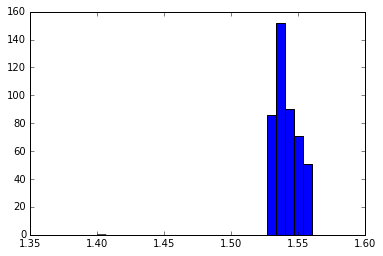

In [13]:
# Input stuff

nsteps = 500
maxchange = 0.5
def prior(theta):
    """Uniform prior for this parameter"""
    if theta < 0.5:
        return 0
    elif theta > 2.0:
        return 0
    else: return 1
equilsteps = 50 #Discard data up to this step number from plots/stats

# Init storage for energies and parameter values
energies = np.zeros((nsteps), np.float32)
param_vals = np.zeros((nsteps), np.float32)



# Do MC
paramval = float(dummyval) #Starting parameter value
params[param_key]=str(paramval)
moveff.setParameter(params, smirks=smirks)
system=moveff.createSystem(topology, [mol])
olden = get_minimum_energy(system, topology, refpos) #Starting energy
oldlog, oldlike = log_likelihood(olden, avgen, unc)
accepted = 0
for step in range(nsteps):
    # Propose move
    chg = random.uniform(-maxchange,maxchange)
    newparam = paramval+chg
    # Focus only on things for which prior isn't zero
    while prior(newparam)==0:
        chg = random.uniform(-maxchange,maxchange)
        newparam = paramval+chg

    # Prep for energy evaluation
    params[param_key]=str(newparam)
    moveff.setParameter(params, smirks=smirks)

    # Get new energy and likelihood
    system=moveff.createSystem(topology, [mol])
    newen = get_minimum_energy(system, topology, refpos)
    newlog, newlike = log_likelihood(newen, avgen, unc)
    
    # Accept or reject move
    Pacc = newlike*prior(newparam)/(oldlike*prior(paramval))
    if step%100==0:
        # Print some progress info every 100 steps
        print("Step %s; current parameter value %.3g." % (step, paramval))
    if random.random() < Pacc: #Accept
        # Update "old" stuff if we accepted
        olden = newen
        oldlog, oldlike = newlog, newlike
        paramval = newparam
        accepted+=1
        
    # Store data regardless
    energies[step] = olden
    param_vals[step] = paramval
print("Acceptance ratio %.2f" % (float(accepted)/float(nsteps)))
hist = pl.hist(param_vals[equilsteps:], range=(1.4, 1.6), bins=30)
print("Mean parameter value %.3g (std %.3g)" % ( param_vals[equilsteps:].mean(), param_vals[equilsteps:].std()))
# Original parameter value?
params = ff.getParameter(smirks=smirks)
print("Original parameter value %.3g" % float(params[param_key]))

# TO DO: Plot a scan of likelihood function on top of this
print(param_vals)

In [33]:
topology = generateTopologyFromOEMol(mol)
    
tmpff = copy.deepcopy(ff)
system=tmpff.createSystem(topology, [mol])
cpositions=reformat_oemol_coordinates(mol)
print get_energy(system, cpositions[:,:,0])
params = tmpff.getParameter(smirks=smirks)
params[param_key]=str(0.1)
tmpff.setParameter(params, smirks=smirks)
system=tmpff.createSystem(topology, [mol])
print get_energy(system, cpositions[:,:,0])

3.3312314599
2.1189779949


## What to do next

* Fall back on simple energy evaluations of a single conformation since it's faster, and doesn't introduce the bias this test does (where we're fitting parameters to make a single-conformation energy equal to an average energy across multiple conformers - some of which are higher in energy). We won't have an uncertainty then, but we can make one up to use across datapoints - i.e. take a few reference molecules, look at uncertainty across conformations, and then use that uncertainty across all molecules.
* Confirm that sampling a single parameter to reproduce a single-point energy for that molecule recovers the correct parameter
* Expand to sampling multiple (two) parameters simultaneously to see how that reduces constraints
* Expand to using multiple molecules for reference data to see how that constrains again

I'll do these in another IPython notebook


## Other things to explore


### Thoughts from 8/3/16 meeting:
Gilson suggestion: See what happens if we introduce error into some of reference energies as a test, i.e. random variation in reference energies. (If you fit to nonsense, you probably can't nail it but maybe you can get close to it -- but lots of variation in parameters presumably -- but if you fit to good data, maybe it actually constraint the parameters somewhat).

(Another test - take same reference trajectory and jumble the reference energies across snapshots.)

Across 1400 molecules, energy will actually constrain these few parameters very tightly, in all likelihood.

No point initially in even doing trajectories. That's the equivalent of the high throughput assay, just do single-point energies. Then the cell-based assay equivalent is to minimize and compare geometries.

### Other things to eventually try
* Can I create a multiple minimum problem, i.e. what if I adjust the OH and HO radii simultaneously? 
* Use a prior which biases things the wrong way